# Mice and the wolf

Miniproject by Alexandra Bereznikova, Anna Logetskaia, Elizaveta Pivovarova.

Opening the python session and importing the libs:

In [1]:
from simulator_interface import open_session, close_session
simulator, epuck1, epuck2, epuck3 = open_session(n_epucks=3)

import matplotlib.pyplot as plt

Leaving the close_session code for debug purposes.

In [ ]:
close_session(simulator)

## Experiment 1

In the first experiment, we will add the two mice and the wolf on the scene. 
The mice will be constantly moving around the scene and eating spheres, while the wolf will be moving around the scene and chasing them on detection. 
If the mouse is too hungry, then the foraging behavior will outweigh its fear towards the wolf.

1. Setting up the agents – two mice and the wolf:

In [2]:
epuck1.species = "mouse"
epuck1.id=1
epuck1.dead=False
epuck1.speed = 0.9

epuck2.species = "mouse"
epuck2.id=2
epuck2.dead=False
epuck2.speed = 0.9

epuck3.species = "wolf"
epuck3.speed = 0.2
epuck3.dead=False

epuck1.energy_level = 1
epuck2.energy_level = 1 
epuck3.energy_level = 1 

Routine die started
Routine epuck_log started
Routine foraging_drive started
Behavior obstacle_avoidance started
Behavior foraging_spheres started
Behavior fear started
Routine epuck_log started
Routine die started
Routine foraging_drive started
Behavior obstacle_avoidance started
Behavior foraging_spheres started
Behavior fear started


2. Defining routines and behaviors for the mice.

In [ ]:
# Foraging routine is used to constantly change the energy level depending on whether the mouse has eaten
def foraging_drive(robot): 
    if robot.dead: 
        return # If the mouse is dead, the energy level stays static    
    if robot.has_eaten():
        robot.energy_level += 0.2  # If the mouse has eaten a sphere, increase its energy level by 0.2
    else:
        robot.energy_level -= 0.01  # Otherwise (nothing eaten), decrease the energy level by 0.01
    # The line below bounds the value of the energy level between 0 and 1
    robot.energy_level = min(1., max(robot.energy_level, 0.))
    

# Foraging behavior is used to ensure that the mouse is looking for spheres to eat
def foraging_spheres(robot):
    if robot.dead==True:
        return 0,0,1 # If the mouse is dead, the mouse stays static with the energy level 0  
    left, right = robot.prox_activations(tracked_objects=["Sphere"])
    left_activation = right
    right_activation = left
    return left_activation, right_activation, 1-robot.energy_level

# Obstacle avoidance behavior is used to ensure that the mouse keeps moving around the scene
def obstacle_avoidance(robot):
    if robot.dead==True:
        return 0,0,1
    left, right = robot.prox_activations(tracked_objects=["20cm", "Tree", "ePuck"]) # Avoid walls, trees and the other agents
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel, robot.energy_level

# Fear behavior is used to ensure that the mouse stays away from the wolf
def fear(robot):
    if robot.dead==True:
        return 0,0,1 # If the mouse is dead, the mouse stays static with the energy level 0  
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_species, right_species = robot.sensed_epuck_attributes(epuck_left, epuck_right, "species", default_value ="none")
    # If the wolf is detected from the left or from the right, turn in the opposite direction. 
    left_activation = left if left_species == "wolf" else 0
    right_activation = right if right_species == "wolf" else 0
    return left_activation, right_activation, robot.energy_level

# Die routine is used to block the mouse in place if it was eaten by a wolf
def die(robot):
    if robot.dead == True:
        robot.left_spd = 0
        robot.right_spd = 0

# Log routine is used to log the mouse energy level and dead / alive status
def epuck_log(robot):
    robot.add_log("energy_level", robot.energy_level)
    robot.add_log("alive", not robot.dead)

3. Attach behaviors and routines to the mice and start them on the scene.

In [ ]:
epuck1.detach_all_behaviors()
epuck1.detach_all_routines()
epuck1.attach_behavior(obstacle_avoidance, freq=10)
epuck1.attach_behavior(foraging_spheres, freq=10)
epuck1.attach_behavior(fear, freq=10)
epuck1.attach_routine(die, freq=10)
epuck1.attach_routine(epuck_log, freq=1)
epuck1.attach_routine(foraging_drive, freq=1)
epuck1.start_all_routines()
epuck1.start_all_behaviors()

epuck2.detach_all_behaviors()
epuck2.detach_all_routines()
epuck2.attach_behavior(obstacle_avoidance, freq=10)
epuck2.attach_behavior(foraging_spheres, freq=10)
epuck2.attach_behavior(fear, freq=10)
epuck2.attach_routine(epuck_log, freq=1)
epuck2.attach_routine(die, freq=10)
epuck2.attach_routine(foraging_drive, freq=1)
epuck2.start_all_routines()
epuck2.start_all_behaviors()

4. Watching how the mice are moving around the scene while changing their energy level. Now trying with the first mouse.

Text(0, 0.5, 'energy_level')

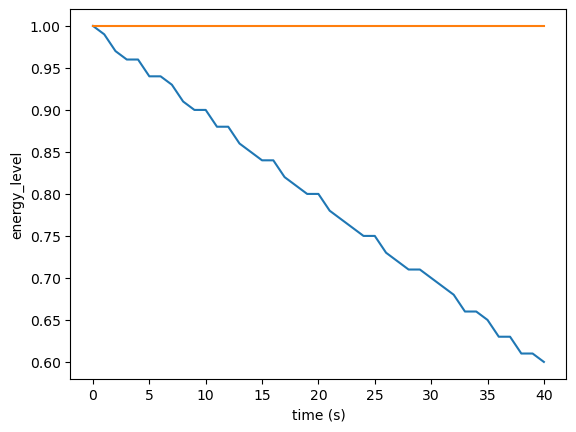

In [4]:
plt.plot(epuck1.get_log("energy_level"))
plt.plot(epuck1.get_log("alive"))

plt.xlabel('Time (s)')
plt.ylabel('Energy level')

5. Adding food to the scene. 

In [ ]:
simulator.start_sphere_apparition(period=5, min_pos=[-1.43,-0.75,0], max_pos=[0.81,0.94,0])

Leaving the stop_sphere_apparition code for debug purposes. 

In [ ]:
simulator.stop_sphere_apparition()

6. Watching how the mice are moving around the scene and eating speheres – energy level is now increasing at the moment of foraging. Now trying with the second mouse.

Text(0, 0.5, 'energy_level')

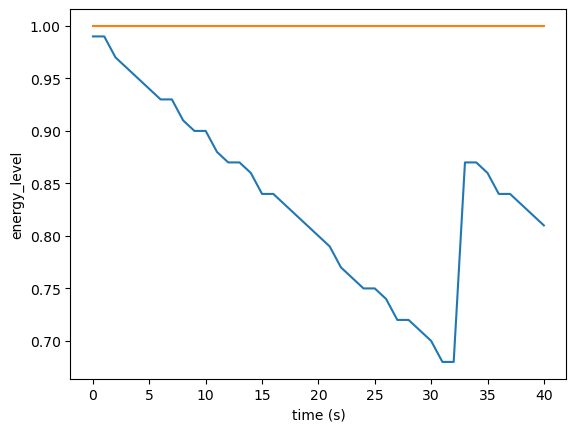

In [5]:
plt.plot(epuck2.get_log("energy_level"))
plt.plot(epuck2.get_log("alive"))

plt.xlabel('Time (s)')
plt.ylabel('Energy level')

7. Defining routines and behaviors for the wolf.

In [6]:
# Obstacle avoidance behavior is used to ensure that the wolf keeps moving around the scene
# Unlike the mice, the wolf should not avoid the mice 
def wolf_obstacle_avoidance(robot):
    left, right = robot.prox_activations(tracked_objects=["20cm", "Tree"])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel, 1

# Aggression behavior is used to ensure that the wolf haunts the mice
def aggression(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    left_is_dead, right_is_dead = robot.sensed_epuck_attributes(epuck_left, epuck_right, "dead", default_value ="none")
    
    left_wheel = left
    right_wheel = right
    
    # Do not haunt the dead mice
    if left_is_dead == False:
        return right_wheel,left_wheel, 1
    if right_is_dead == False:
        return right_wheel,left_wheel, 1
    return left_wheel, right_wheel, 1

# Foraging routine is used to constantly decrease the energy level of the wolf
def wolf_foraging_drive(robot): 
    robot.energy_level -= 0.01
    robot.energy_level = min(1., max(robot.energy_level, 0.))
    
# Kill routine is used to set mouse.dead parameter to true in case it was "caught" by a wolf
def kill(robot):
    (left, right), (epuck_left, epuck_right) = robot.prox_activations(tracked_objects=["ePuck"], return_epucks=True)
    if left > 0.95 and left != None:
        epuck_left.dead=True
        robot.energy_level = min(0.7, robot.energy_level+0.5)
    if right > 0.95 and right != None:
        epuck_right.dead=True
        robot.energy_level = min(0.7, robot.energy_level+0.5)

Behavior wolf_obstacle_avoidance started
Behavior aggression started
Routine wolf_foraging_drive started
Routine kill started


8. Attach behaviors and routines to the wolf and start it on the scene.

In [ ]:
epuck3.detach_all_behaviors()
epuck3.detach_all_routines()
epuck3.attach_behavior(wolf_obstacle_avoidance, freq=10)
epuck3.attach_routine(wolf_foraging_drive, freq=1)
epuck3.attach_behavior(aggression, freq=10)
epuck3.attach_routine(kill, freq=10)
epuck3.start_all_behaviors()
epuck3.start_all_routines()

## Experiment 2

In the second experiment, we will add speed control to the wolf and the mice to balance their chances to survive.
The mouse will speed up if it is hungry, while the wolf will slow down if it is hungry. 

1. Adding the speed control and update the logs of the mice.

In [ ]:
# Speed control routine is needed to change the speed proportionally to the mouse energy level
# If the mouse "overate", the speed is lower
def speed_control(robot): 
    if robot.dead: # If the robot is dead, the speed does not change
        return    
    if robot.energy_level > 0.4: 
        # Max speed depends on the energy level and changes in the interval (0.5, 0.9)             
        robot.max_speed = 1-robot.energy_level+0.1
        
# Log routine now writes the current max speed     
def epuck_log(robot):
    robot.add_log("energy_level", robot.energy_level)
    robot.add_log("alive", not robot.dead)
    robot.add_log("max_speed", robot.max_speed)

2. Adding the speed control and set the logs of the wolf.

In [7]:
# Speed control routine is needed to change the speed proportionally to the wolf energy level
# If the wolf is hungry, the speed is lower
def wolf_speed_control(robot): 
    # Max speed depends on the energy level and changes in the interval (0.1, 0.7)     
    if robot.energy_level > 0.4 and robot.energy_level < 0.7:
        robot.max_speed = robot.energy_level

# Log routine is used to log the wolf energy level and current max speed
def wolf_epuck_log(robot):
    robot.add_log("energy_level", robot.energy_level)
    robot.add_log("max_speed", robot.max_speed)

Routine die started
Routine epuck_log started
Routine foraging_drive started
Behavior obstacle_avoidance started
Behavior foraging_spheres started
Behavior fear started
Routine epuck_log started
Routine die started
Routine speed_control started
Routine foraging_drive started
Behavior obstacle_avoidance started
Behavior foraging_spheres started
Behavior fear started
Behavior wolf_obstacle_avoidance started
Behavior aggression started
Routine wolf_epuck_log started
Routine wolf_foraging_drive started
Routine wolf_speed_control started
Routine kill started


3. Setting up the mice and wolf, update their behaviors and routines and start them on the scene.

In [ ]:
epuck1.energy_level = 0.9
epuck2.energy_level = 0.9 
epuck3.energy_level = 0.7 

epuck1.detach_all_behaviors()
epuck1.detach_all_routines()
epuck1.attach_behavior(obstacle_avoidance, freq=10)
epuck1.attach_behavior(foraging_spheres, freq=10)
epuck1.attach_behavior(fear, freq=10)
epuck1.attach_routine(die, freq=10)
epuck2.attach_routine(speed_control, freq=1)
epuck1.attach_routine(epuck_log, freq=1)
epuck1.attach_routine(foraging_drive, freq=1)
epuck1.start_all_routines()
epuck1.start_all_behaviors()

epuck2.detach_all_behaviors()
epuck2.detach_all_routines()
epuck2.attach_behavior(obstacle_avoidance, freq=10)
epuck2.attach_behavior(foraging_spheres, freq=10)
epuck2.attach_behavior(fear, freq=10)
epuck2.attach_routine(epuck_log, freq=1)
epuck2.attach_routine(die, freq=10)
epuck2.attach_routine(speed_control, freq=1)
epuck2.attach_routine(foraging_drive, freq=1)
epuck2.start_all_routines()
epuck2.start_all_behaviors()

epuck3.detach_all_behaviors()
epuck3.detach_all_routines()
epuck3.attach_behavior(wolf_obstacle_avoidance, freq=10)
epuck3.attach_behavior(aggression, freq=10)
epuck3.attach_routine(wolf_epuck_log, freq=1)
epuck3.attach_routine(wolf_foraging_drive, freq=1)
epuck3.attach_routine(wolf_speed_control, freq=1)
epuck3.attach_routine(kill, freq=10)
epuck3.start_all_behaviors()
epuck3.start_all_routines()

3. Watching how the mice are moving around the scene with energy level changing and max speed changing accordingly.

In [ ]:
plt.plot(epuck1.get_log("energy_level"))
plt.plot(epuck1.get_log("alive"))
plt.plot(epuck1.get_log("max_speed"))

plt.xlabel('Time (s)')
plt.ylabel('Energy level')

In [ ]:
plt.plot(epuck2.get_log("energy_level"))
plt.plot(epuck2.get_log("alive"))
plt.plot(epuck2.get_log("max_speed"))

plt.xlabel('Time (s)')
plt.ylabel('Energy level')

4. Watching how the wolf is moving around the scene with energy level changing and max speed changing accordingly.

In [ ]:
plt.plot(epuck3.get_log("energy_level"))
plt.plot(epuck3.get_log("max_speed"))

plt.xlabel('Time (s)')
plt.ylabel('Energy level')

# Future work